In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [38]:
# Fungsi untuk memuat dataset
def scan_and_load_images(base_folder, target_size=(64, 64)):
    # Data generator dengan rescaling saja (tanpa augmentasi)
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2  # 20% untuk validasi
    )

    # Generator untuk training
    train_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='rgb',           # Warna (tidak grayscale)
        batch_size=32,
        class_mode='binary',        # Binary classification
        subset='training',          # Data training
        shuffle=True
    )

    # Generator untuk validasi
    validation_generator = datagen.flow_from_directory(
        base_folder,
        target_size=target_size,
        color_mode='rgb',           # Warna (tidak grayscale)
        batch_size=32,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator

In [39]:

# Path ke dataset
dataset_path = 'D:\\projek\\FIX\\drowsiness-detection\\test_processing'


In [40]:
# Panggil fungsi untuk memuat data
train_generator, validation_generator = scan_and_load_images(dataset_path)

# Print label mapping
print("Class indices:", train_generator.class_indices)


Found 2059 images belonging to 2 classes.
Found 513 images belonging to 2 classes.
Class indices: {'mengantuk': 0, 'tidak_mengantuk': 1}


In [97]:
# Model CNN
def build_drowsiness_detection_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

In [98]:
# Input shape
input_shape = (64, 64, 3)  # (64, 64, 3) karena tdk grayscale


In [99]:
# Inisialisasi model
model = build_drowsiness_detection_model(input_shape)


In [100]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [101]:
# Callback untuk early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [102]:
# Training model
print("\n=== Training Model ===")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)


=== Training Model ===
Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.7893 - loss: 0.6090 - val_accuracy: 0.5029 - val_loss: 1.3121
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.9398 - loss: 0.1709 - val_accuracy: 0.5029 - val_loss: 1.9509
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9647 - loss: 0.1086 - val_accuracy: 0.5029 - val_loss: 2.0514
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.9540 - loss: 0.1148 - val_accuracy: 0.6082 - val_loss: 0.8899
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9692 - loss: 0.0794 - val_accuracy: 0.7096 - val_loss: 0.7044
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 248ms/step - accuracy: 0.9800 - loss: 0.0616 - val_accuracy: 0.7661 - val_loss: 0.5906
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.9802 - loss: 0.0536 - val_accuracy: 0.8187 - val_loss: 0.4435
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.9803 -

In [103]:
# Evaluasi dengan generator validasi
print("\n=== Evaluasi Model ===")
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")



=== Evaluasi Model ===
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9732 - loss: 0.0960
Validation Loss: 0.1124
Validation Accuracy: 0.9688



=== Evaluasi dengan Confusion Matrix ===
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


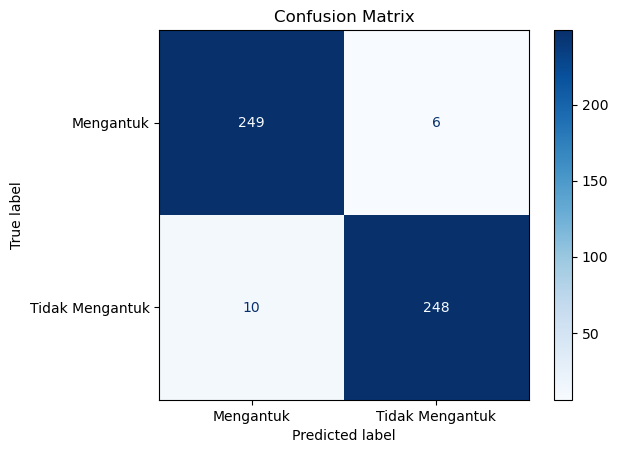


Classification Report:
                 precision    recall  f1-score   support

      Mengantuk       0.96      0.98      0.97       255
Tidak Mengantuk       0.98      0.96      0.97       258

       accuracy                           0.97       513
      macro avg       0.97      0.97      0.97       513
   weighted avg       0.97      0.97      0.97       513



In [104]:
# Prediksi pada data validasi
print("\n=== Evaluasi dengan Confusion Matrix ===")
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int).flatten()  # Binarisasi output (0 atau 1)

# Ambil label asli
y_true = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mengantuk", "Tidak Mengantuk"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Mengantuk", "Tidak Mengantuk"]))


In [ ]:
# Setelah evaluasi model dan sebelum menyimpan model
from sklearn.metrics import roc_curve, auc

# Hitung probabilitas prediksi untuk data validasi
validation_generator.reset()  # Pastikan generator di-reset
y_probs = model.predict(validation_generator)  # Probabilitas prediksi (output sigmoid)

# Ambil label asli
y_true = validation_generator.classes

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Cari threshold optimal (titik dengan TPR tinggi dan FPR rendah)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Garis diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Gunakan threshold optimal untuk prediksi baru
y_pred_optimal = (y_probs > optimal_threshold).astype(int).flatten()

# Confusion Matrix dengan threshold optimal
cm_optimal = confusion_matrix(y_true, y_pred_optimal)
disp_optimal = ConfusionMatrixDisplay(confusion_matrix=cm_optimal, display_labels=["Mengantuk", "Tidak Mengantuk"])
disp_optimal.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Threshold")
plt.show()

# Classification Report dengan threshold optimal
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_true, y_pred_optimal, target_names=["Mengantuk", "Tidak Mengantuk"]))



NameError: name 'validation_generator' is not defined

In [14]:
model.save('drowsiness_detection_model_after.h5')
print("Model telah disimpan dalam format .h5")

Model telah disimpan dalam format .h5


Validation Accuracy (terakhir): 94.15%
Validation Loss (terakhir): 0.1789


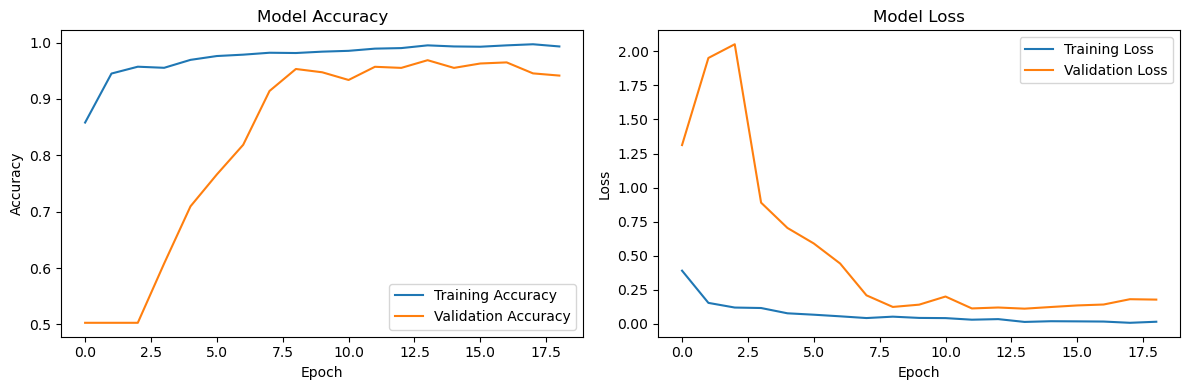

In [106]:

# Mendapatkan nilai terakhir dari validasi akurasi dan loss
final_val_accuracy = history.history.get('val_accuracy', history.history.get('val_categorical_accuracy'))[-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Validation Accuracy (terakhir): {final_val_accuracy * 100:.2f}%")
print(f"Validation Loss (terakhir): {final_val_loss:.4f}")

# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [107]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib

# Load model
model_path = "drowsiness_detection_model_after.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None

    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri dan kanan
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            return cv2.resize(roi, (64, 64), interpolation=cv2.INTER_CUBIC) / 255.0

        left_eye = crop_roi(left_eye_points)
        right_eye = crop_roi(right_eye_points)
        mouth = crop_roi(mouth_points)

        # Gabungkan mata kiri, kanan, dan mulut dalam satu batch
        return {
            "left_eye": np.expand_dims(left_eye, axis=0),
            "right_eye": np.expand_dims(right_eye, axis=0),
            "mouth": np.expand_dims(mouth, axis=0),
        }

# Daftar gambar untuk prediksi
image_paths = ["D:\\pcv\\test data\\test.jpg", "D:\\pcv\\test data\\mengantuk 4.jpeg"]

# Perbaharui proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(rois["left_eye"])[0][0]
        right_eye_pred = model.predict(rois["right_eye"])[0][0]
        mouth_pred = model.predict(rois["mouth"])[0][0]

        # Hitung rata-rata prediksi sebagai hasil akhir
        final_prediction = (left_eye_pred + right_eye_pred + mouth_pred) / 3

        # Tentukan label dan confidence
        if final_prediction < 0.7:
            label = "Mengantuk"
            confidence = 1 - final_prediction
        else:
            label = "Tidak Mengantuk"
            confidence = final_prediction

        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")


Model berhasil dimuat dari: drowsiness_detection_model_after.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: D:\pcv\test data\test.jpg
Predicted Label: Tidak Mengantuk (Confidence: 1.00)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: D:\pcv\test data\mengantuk 4.jpeg
Predicted Label: Mengantuk (Confidence: 0.65)



Model berhasil dimuat dari: drowsiness_detection_model_after.h5


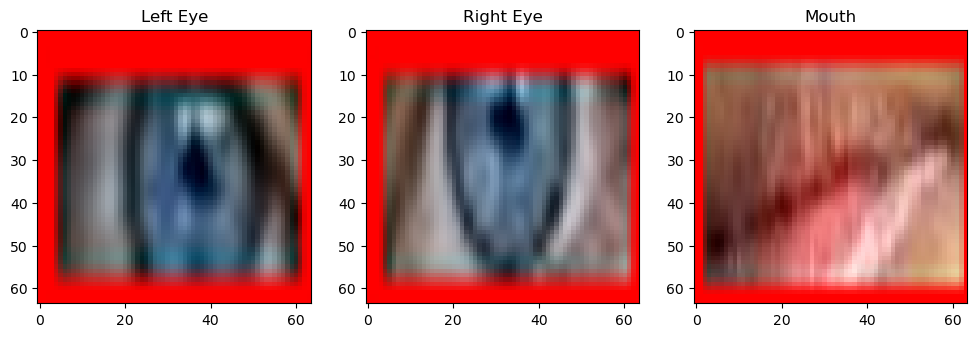

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: D:\pcv\test data\test.jpg
Predicted Label: Tidak Mengantuk (Confidence: 1.00)



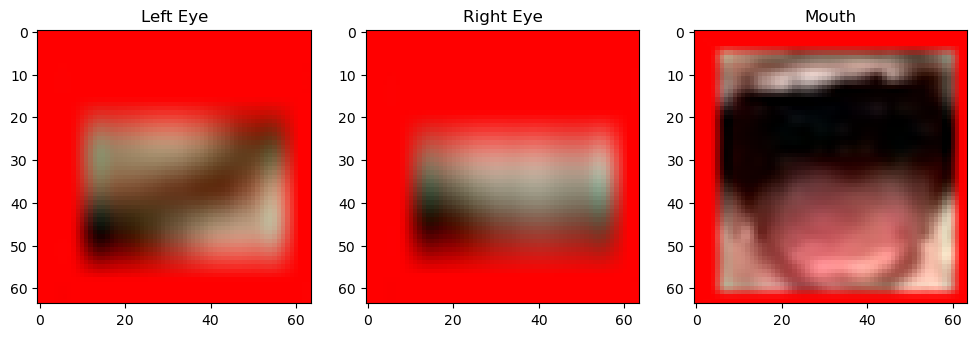

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: D:\pcv\test data\mengantuk 4.jpeg
Predicted Label: Mengantuk (Confidence: 1.00)



In [52]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
import dlib
import matplotlib.pyplot as plt

# Load model
model_path = "drowsiness_detection_model_after.h5"
try:
    model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model: {e}")
    exit()

# Load predictor untuk landmark wajah
predictor_path = 'data/shape_predictor_68_face_landmarks.dat'
if not os.path.exists(predictor_path):
    print(f"File landmark predictor tidak ditemukan: {predictor_path}")
    exit()

predictor = dlib.shape_predictor(predictor_path)

def preprocess_eye_mouth(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to read image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    detector = dlib.get_frontal_face_detector()
    faces = detector(img_rgb, 1)
    if len(faces) == 0:
        print(f"No face detected in image: {image_path}")
        return None, None

    rois = {}
    for face in faces:
        rect = dlib.rectangle(face.left(), face.top(), face.right(), face.bottom())
        landmarks = predictor(img_rgb, rect)
        landmarks = face_utils.shape_to_np(landmarks)

        # Ambil mata kiri, kanan, dan mulut
        left_eye_points = landmarks[36:42]
        right_eye_points = landmarks[42:48]
        mouth_points = landmarks[48:68]

        # Ekstrak bounding box untuk mata dan mulut
        def crop_roi(points, label):
            (x_min, y_min) = points.min(axis=0)
            (x_max, y_max) = points.max(axis=0)
            roi = img_rgb[y_min:y_max, x_min:x_max]
            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            return cv2.resize(roi, (64, 64), interpolation=cv2.INTER_CUBIC) / 255.0

        rois["left_eye"] = crop_roi(left_eye_points, "left_eye")
        rois["right_eye"] = crop_roi(right_eye_points, "right_eye")
        rois["mouth"] = crop_roi(mouth_points, "mouth")

        # Gambar landmark dan bounding box pada gambar asli
        for (x, y) in landmarks:
            cv2.circle(img_rgb, (x, y), 1, (0, 255, 0), -1)

    return img_rgb, rois

def display_images(original, rois):
    # Tampilkan gambar asli dengan bounding box
    cv2.imshow("Original with Bounding Boxes", cv2.cvtColor(original, cv2.COLOR_RGB2BGR))

    # Tampilkan masing-masing ROI (Mata Kiri, Mata Kanan, Mulut)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(rois["left_eye"])
    axes[0].set_title("Left Eye")
    axes[1].imshow(rois["right_eye"])
    axes[1].set_title("Right Eye")
    axes[2].imshow(rois["mouth"])
    axes[2].set_title("Mouth")
    plt.show()

# Daftar gambar untuk prediksi
image_paths = ["D:\\pcv\\test data\\test.jpg", "D:\\pcv\\test data\\mengantuk 4.jpeg"]

# Perbaharui proses prediksi
for image_path in image_paths:
    if not os.path.exists(image_path):
        print(f"Gambar tidak ditemukan: {image_path}")
        continue

    original, rois = preprocess_eye_mouth(image_path)
    if rois is not None:
        # Tampilkan gambar asli dan hasil preprocess
        display_images(original, rois)

        # Prediksi untuk masing-masing ROI
        left_eye_pred = model.predict(np.expand_dims(rois["left_eye"], axis=0))[0][0]
        right_eye_pred = model.predict(np.expand_dims(rois["right_eye"], axis=0))[0][0]
        mouth_pred = model.predict(np.expand_dims(rois["mouth"], axis=0))[0][0]

        # Hitung rata-rata prediksi sebagai hasil akhir
        final_prediction = (left_eye_pred + right_eye_pred + mouth_pred) / 3

        # Tentukan label dan confidence
        if final_prediction < 0.7:
            label = "Mengantuk"
            confidence = 1 - final_prediction
        else:
            label = "Tidak Mengantuk"
            confidence = final_prediction

        # Output hasil
        print(f"Image: {image_path}")
        print(f"Predicted Label: {label} (Confidence: {confidence:.2f})\n")
    else:
        print(f"Gagal memproses gambar: {image_path}\n")

# Tunggu hingga semua jendela ditutup
cv2.waitKey(0)
cv2.destroyAllWindows()
